In [3]:
path = "/home/stan/ApacheSpark/MLwithSpark/Regression/hour_noheader.csv"

In [4]:
raw_data = sc.textFile(path)

In [5]:
num_data=raw_data.count()

In [6]:
records = raw_data.map(lambda x: x.split(","))

In [7]:
first = records.first()

In [8]:
print first

[u'1', u'2011-01-01', u'1', u'0', u'1', u'0', u'0', u'6', u'0', u'1', u'0.24', u'0.2879', u'0.81', u'0', u'3', u'13', u'16']


In [9]:
print num_data

17379


# Binary Encoding

In [10]:
def get_mapping(rdd,idx):
    return rdd.map(lambda fields: fields[idx]).distinct().zipWithIndex().collectAsMap()

In [11]:
print "Mapping of first categorical feature column: %s" %get_mapping(records,2)

Mapping of first categorical feature column: {u'1': 0, u'3': 1, u'2': 2, u'4': 3}


In [12]:
mappings = [get_mapping(records,i) for i in range(2,10)]

In [13]:
cat_len = sum(map(len,mappings))

In [14]:
cat_len

57

In [15]:
num_len = len(records.first()[11:15])

In [16]:
records.first()[11:15]

[u'0.2879', u'0.81', u'0', u'3']

In [17]:
total_len = num_len+cat_len

In [18]:
print "Feature vector length for categorical features: %s" %cat_len

Feature vector length for categorical features: 57


In [19]:
from pyspark.mllib.regression import LabeledPoint

In [20]:
import numpy as np

In [21]:
def extract_features(record):
    cat_vec = np.zeros(cat_len)
    i = 0
    step = 0
    for field in record[2:9]:
        m = mappings[i]
        idx = m[field]
        cat_vec[idx+step] =1
        i = i+1
        step =step + len(m)
    num_vec = np.array([float(field) for field in record[10:14]])
    return np.concatenate((cat_vec,num_vec))

        

In [22]:
def extract_label(record):
    return float(record[-1])

In [23]:
data = records.map(lambda r: LabeledPoint(extract_label(r),extract_features(r)))

In [24]:
first_point = data.first()

In [25]:
print "Raw data:" + str(first[2:])

Raw data:[u'1', u'0', u'1', u'0', u'0', u'6', u'0', u'1', u'0.24', u'0.2879', u'0.81', u'0', u'3', u'13', u'16']


In [26]:
print "Label:" + str(first_point.label)

Label:16.0


In [27]:
print "Linear Model feature vector: \n" + str(first_point.features)

Linear Model feature vector: 
[1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.24,0.2879,0.81,0.0]


In [28]:
def extract_features_dt(record):
    return np.array(map(float,record[2:14]))


In [29]:
data_dt = records.map(lambda r: LabeledPoint(extract_label(r),extract_features_dt(r)))

In [30]:
first_point_dt = data_dt.first()

In [31]:
str(first_point_dt.features)

'[1.0,0.0,1.0,0.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0]'

In [32]:
from pyspark.mllib.regression import LinearRegressionWithSGD

In [33]:
from pyspark.mllib.tree import DecisionTree

In [34]:
help(LinearRegressionWithSGD.train)

Help on method train in module pyspark.mllib.regression:

train(cls, data, iterations=100, step=1.0, miniBatchFraction=1.0, initialWeights=None, regParam=0.0, regType=None, intercept=False, validateData=True) method of __builtin__.type instance
    Train a linear regression model using Stochastic Gradient
    Descent (SGD).
    This solves the least squares regression formulation
    
        f(weights) = 1/(2n) ||A weights - y||^2,
    
    which is the mean squared error.
    Here the data matrix has n rows, and the input RDD holds the
    set of rows of A, each with its corresponding right hand side
    label y. See also the documentation for the precise formulation.
    
    :param data:              The training data, an RDD of
                              LabeledPoint.
    :param iterations:        The number of iterations
                              (default: 100).
    :param step:              The step parameter used in SGD
                              (default: 1.0).
    :

In [35]:
help(DecisionTree.trainRegressor)

Help on method trainRegressor in module pyspark.mllib.tree:

trainRegressor(cls, data, categoricalFeaturesInfo, impurity='variance', maxDepth=5, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0) method of __builtin__.type instance
    Train a DecisionTreeModel for regression.
    
    :param data: Training data: RDD of LabeledPoint.
                 Labels are real numbers.
    :param categoricalFeaturesInfo: Map from categorical feature
             index to number of categories.
             Any feature not in this map is treated as continuous.
    :param impurity: Supported values: "variance"
    :param maxDepth: Max depth of tree.
             E.g., depth 0 means 1 leaf node.
             Depth 1 means 1 internal node + 2 leaf nodes.
    :param maxBins: Number of bins used for finding splits at each
             node.
    :param minInstancesPerNode: Min number of instances required at
             child nodes to create the parent split
    :param minInfoGain: Min info gain requir

In [36]:
linear_model = LinearRegressionWithSGD.train(data,iterations=10,step=0.1,intercept=False)

In [37]:
true_vs_predicted = data.map(lambda p: (p.label,linear_model.predict(p.features)))

In [38]:
print "Linear Model predictions: "+ str(true_vs_predicted.take(5)) 

Linear Model predictions: [(16.0, 117.89250386724845), (40.0, 116.2249612319211), (32.0, 116.02369145779235), (13.0, 115.67088016754433), (1.0, 115.56315650834316)]


In [39]:
dt_model = DecisionTree.trainRegressor(data_dt,{})

In [40]:
preds = dt_model.predict(data_dt.map(lambda p: p.features))

In [41]:
actual = data.map(lambda p: p.label)


In [42]:
true_vs_predicted_dt = actual.zip(preds)

In [43]:
print "Decision Tree predictions: " + str(true_vs_predicted_dt.take(5))

Decision Tree predictions: [(16.0, 54.913223140495866), (40.0, 54.913223140495866), (32.0, 53.171052631578945), (13.0, 14.284023668639053), (1.0, 14.284023668639053)]


In [44]:
print "Decision Tree depth: "+ str(dt_model.depth())

Decision Tree depth: 5


In [45]:
print "Decision Tree number of nodes: "+ str(dt_model.numNodes())

Decision Tree number of nodes: 63


# Evaluating the performance of regression models

In [46]:
def squared_error(actual, pred):
    return (pred-actual)**2

In [47]:
def abs_error(actual, pred):
    return np.abs(pred-actual)

In [48]:
def squared_log_error(pred,actual):
    return (np.log(pred+1)-np.log(actual+1))**2

In [49]:
mse = true_vs_predicted.map(lambda(t,p):squared_error(t,p)).mean()

In [50]:
mae = true_vs_predicted.map(lambda(t,p):abs_error(t,p)).mean()

In [51]:
rmsle = np.sqrt(true_vs_predicted.map(lambda (t,p):squared_log_error(t,p)).mean()) ## root mean squared log error

In [52]:
print "Linear Model- Mean squared error, mean absolute error, root mean squared log error: %2.4f, %2.4f, %2.4f" %(mse,mae,rmsle)

Linear Model- Mean squared error, mean absolute error, root mean squared log error: 30679.4539, 130.6429, 1.4653


In [53]:
mse_dt = true_vs_predicted_dt.map(lambda(t,p):squared_error(t,p)).mean()
mae_dt = true_vs_predicted_dt.map(lambda(t,p):abs_error(t,p)).mean()
rmsle_dt = np.sqrt(true_vs_predicted_dt.map(lambda (t,p):squared_log_error(t,p)).mean())

print "Decision Tree model- Mean squared error, mean absolute error, root mean squared log error: %2.4f, %2.4f, %2.4f" %(mse_dt,mae_dt,rmsle_dt)


Decision Tree model- Mean squared error, mean absolute error, root mean squared log error: 11560.7978, 71.0969, 0.6259


# Improving model performance and tuning parameters

In [54]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [55]:
targets = records.map(lambda r: float(r[-1])).collect()

(array([  7.96372860e-03,   3.40527809e-03,   2.69781034e-03,
          2.37473340e-03,   2.27568792e-03,   2.24503098e-03,
          2.12240324e-03,   2.09410453e-03,   1.80875921e-03,
          1.71207195e-03,   1.37720388e-03,   1.37248743e-03,
          1.23099388e-03,   9.64514361e-04,   8.53677747e-04,
          8.65468877e-04,   6.83885488e-04,   5.94272907e-04,
          5.70690649e-04,   4.78719842e-04,   5.02302100e-04,
          3.72599680e-04,   3.49017422e-04,   3.39584518e-04,
          2.52330163e-04,   2.26389679e-04,   2.02807421e-04,
          1.88658066e-04,   1.50926453e-04,   1.29702420e-04,
          9.90454845e-05,   6.36720972e-05,   8.72543554e-05,
          1.01403710e-04,   8.25379038e-05,   5.65974197e-05,
          4.71645164e-05,   1.17911291e-05,   9.43290329e-06,
          1.88658066e-05]),
 array([   1. ,   25.4,   49.8,   74.2,   98.6,  123. ,  147.4,  171.8,
         196.2,  220.6,  245. ,  269.4,  293.8,  318.2,  342.6,  367. ,
         391.4,  415.8

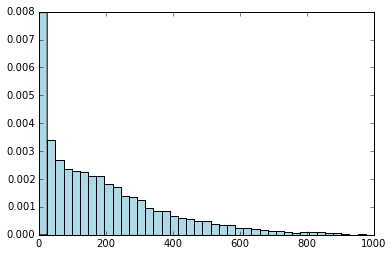

In [56]:
hist(targets, bins= 40, color='lightblue', normed=True)

In [57]:
from matplotlib import pyplot
fig = matplotlib.pyplot.gcf()

In [58]:
fig.set_size_inches(16,10)

In [60]:
log_targets = records.map(lambda r: np.log(float(r[-1]))).collect()

(array([ 0.05282272,  0.        ,  0.        ,  0.        ,  0.06953877,
         0.        ,  0.0748879 ,  0.        ,  0.07722815,  0.08692346,
         0.07889975,  0.06619556,  0.10363951,  0.10096494,  0.07856543,
         0.0621837 ,  0.0956158 ,  0.10497679,  0.1066484 ,  0.1210242 ,
         0.12871358,  0.12135852,  0.13172247,  0.15245037,  0.16649185,
         0.19190025,  0.23235309,  0.26545087,  0.30122321,  0.3376642 ,
         0.38012297,  0.39516741,  0.36842173,  0.3423447 ,  0.30824395,
         0.24472297,  0.20661037,  0.14275506,  0.07689383,  0.03543803]),
 array([ 0.        ,  0.17211217,  0.34422433,  0.5163365 ,  0.68844867,
         0.86056083,  1.032673  ,  1.20478516,  1.37689733,  1.5490095 ,
         1.72112166,  1.89323383,  2.065346  ,  2.23745816,  2.40957033,
         2.58168249,  2.75379466,  2.92590683,  3.09801899,  3.27013116,
         3.44224333,  3.61435549,  3.78646766,  3.95857982,  4.13069199,
         4.30280416,  4.47491632,  4.64702849,  4

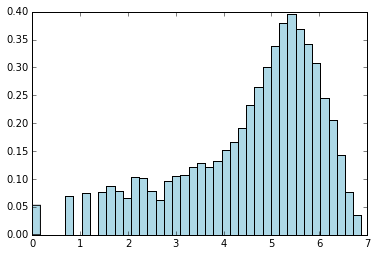

In [61]:
hist(log_targets, bins = 40, color = 'lightblue', normed=True)

In [62]:
fig = matplotlib.pyplot.gcf()

In [63]:
fig.set_size_inches(16,10)

In [64]:
sqrt_targets = records.map(lambda r: np.sqrt(float(r[-1]))).collect()

(array([ 0.04488088,  0.05530237,  0.05043394,  0.05119463,  0.0376543 ,
         0.04609799,  0.04297915,  0.03818678,  0.03887141,  0.04510909,
         0.04001245,  0.04746724,  0.04982538,  0.05073822,  0.05203139,
         0.05385706,  0.05781266,  0.0512707 ,  0.05553058,  0.04564157,
         0.04609799,  0.04214239,  0.03818678,  0.03149269,  0.03217731,
         0.02852598,  0.0222883 ,  0.02198402,  0.02122333,  0.01589848,
         0.01597455,  0.01080184,  0.00988901,  0.00882404,  0.00585734,
         0.00425988,  0.00547699,  0.00342312,  0.00167352,  0.00091283]),
 array([  1.        ,   1.75642498,   2.51284996,   3.26927494,
          4.02569992,   4.7821249 ,   5.53854988,   6.29497486,
          7.05139984,   7.80782482,   8.5642498 ,   9.32067478,
         10.07709976,  10.83352475,  11.58994973,  12.34637471,
         13.10279969,  13.85922467,  14.61564965,  15.37207463,
         16.12849961,  16.88492459,  17.64134957,  18.39777455,
         19.15419953,  19.9106

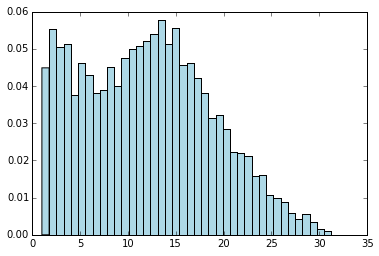

In [65]:
hist(sqrt_targets, bins = 40, color = 'lightblue', normed=True)

In [66]:
fig = matplotlib.pyplot.gcf()

In [67]:
fig.set_size_inches(16,10)

In [68]:
data_log = data.map(lambda lp: LabeledPoint(np.log(lp.label), lp.features))

In [69]:
model_log = LinearRegressionWithSGD.train(data_log,iterations=10, step=0.1)

In [70]:
true_vs_predicted_log = data_log.map(lambda p: (np.exp(p.label), np.exp(model_log.predict(p.features))))

In [73]:
mse_log = true_vs_predicted_log.map(lambda(t,p): squared_log_error(t,p)).mean()

In [74]:
print "Mean Squared Error: %2.4f" % mse_log

Mean Squared Error: 2.3749


In [75]:
data_dt_log = data_dt.map(lambda lp: LabeledPoint(np.log(lp.label),lp.features))

In [76]:
dt_model_log = DecisionTree.trainRegressor(data_dt_log,{})

In [77]:
preds_log = dt_model_log.predict(data_dt_log.map(lambda p: p.features))

In [78]:
actual_log = data_dt_log.map(lambda p: p.label)

In [79]:
true_vs_predicted_dt_log = actual_log.zip(preds_log).map(lambda (t,p): (np.exp(t),np.exp(p)))

In [80]:
mse_log_dt= true_vs_predicted_dt_log.map(lambda (t,p): squared_error(t,p)).mean()

In [81]:
print "Mean Squared error: %s" %mse_log_dt

Mean Squared error: 14781.5759883


# Tuning model parameters, cross validation

In [82]:
data_with_idx = data.zipWithIndex().map(lambda (k,v): (v,k))

In [84]:
test = data_with_idx.sample(False, 0.2, 42)

In [86]:
train = data_with_idx.subtractByKey(test)

In [87]:
train_data = train.map(lambda (idx,p): p)

In [88]:
test_data = test.map(lambda (idx,p): p)

In [89]:
train_size = train_data.count()

In [90]:
test_size = test_data.count()

In [91]:
data_with_idx_dt = data_dt.zipWithIndex().map(lambda (k,v): (v,k))

In [92]:
test_dt= data_with_idx_dt.sample(False, 0.2, 42)

In [93]:
train_dt = data_with_idx_dt.subtractByKey(test_dt)

In [95]:
train_data_dt = train_dt.map(lambda (idx,p): p)

In [96]:
test_data_dt = test_dt.map(lambda (idx,p): p)

In [101]:
def evaluate(train, test, iterations, step, regParam, regType, intercept):
    model = LinearRegressionWithSGD.train(train, iterations, step, regParam = regParam, regType = regType, intercept=intercept)
    tp = test.map(lambda p: (p.label, model.predict(p.features)))
    rmsle = np.sqrt(tp.map(lambda (t,p): squared_log_error(t,p)).mean())
    return rmsle

In [102]:
params =[1,5,10,20,50,100]

In [104]:
metrics=[evaluate(train_data,test_data, param, 0.01, 0.0, 'l2', False) for param in params]

In [105]:
print metrics

[2.8779465130028199, 2.0390187660391499, 1.7761565324837874, 1.5828778102209105, 1.4382263191764473, 1.4050638054019446]


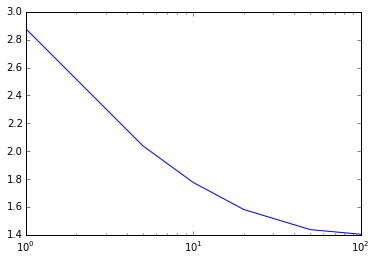

In [109]:
plot(params, metrics)
fig = matplotlib.pyplot.gcf()
pyplot.xscale('log')